In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 165

ng =7

ng_refs = (/ 7 /) 

nref =1

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =257

vstar = 1215

data w_diffuse
     &     /2 , 1.6 , 1.6 , 1.6,
     &     1.6 , 1.6 , 1.8/

data wgt
     &     /0.5 , 0.5 , 0.5 , 0.5,
     &     0.5 , 0.5 , 0.9/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

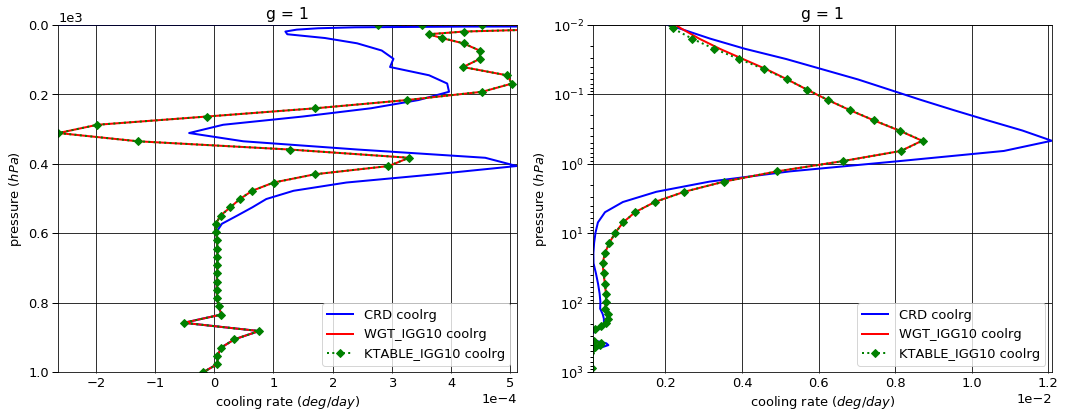

# Figure: cooling rate g-group 2

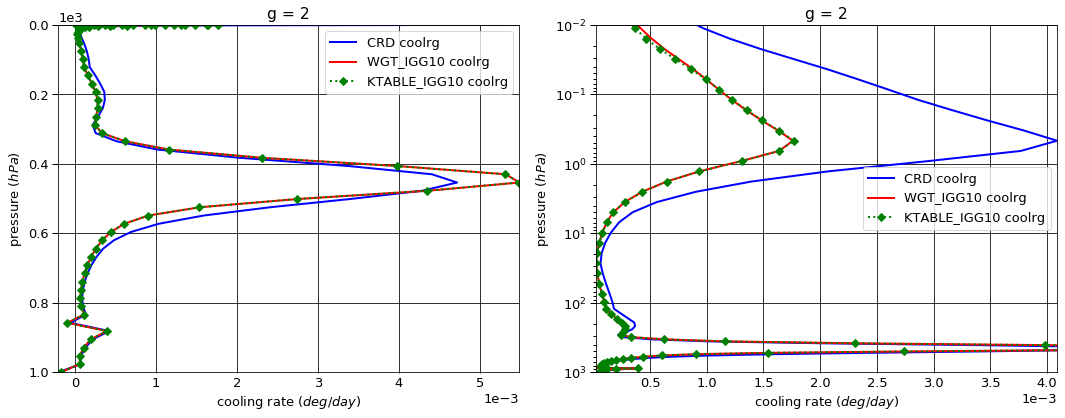

# Figure: cooling rate g-group 3

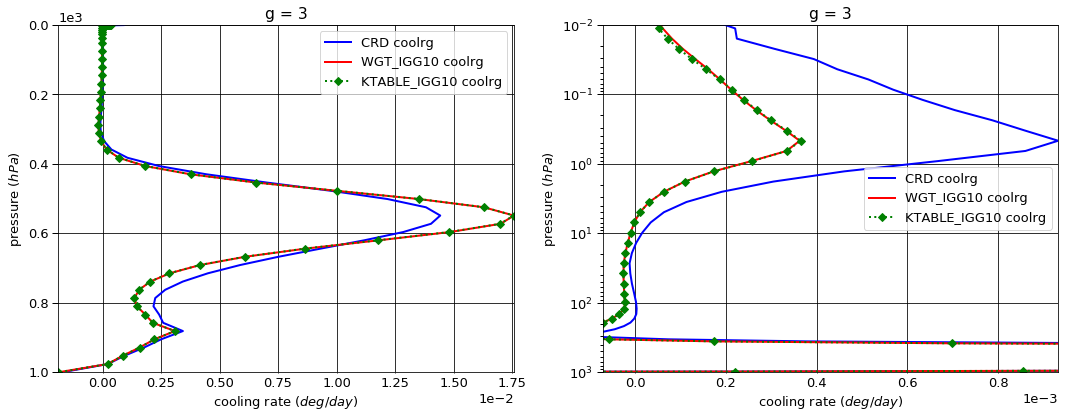

# Figure: cooling rate g-group 4

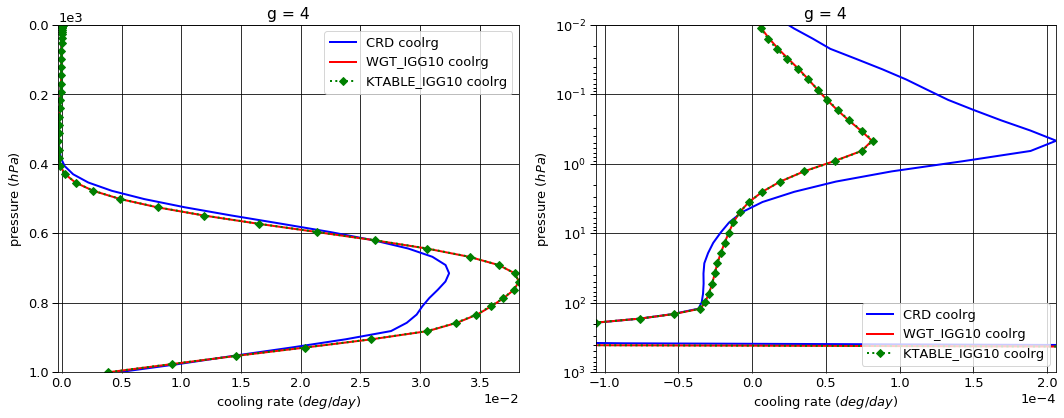

# Figure: cooling rate g-group 5

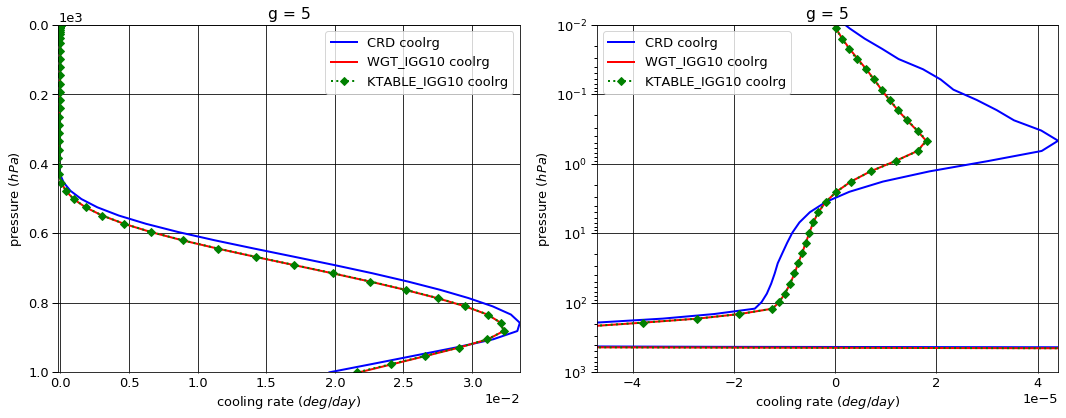

# Figure: cooling rate g-group 6

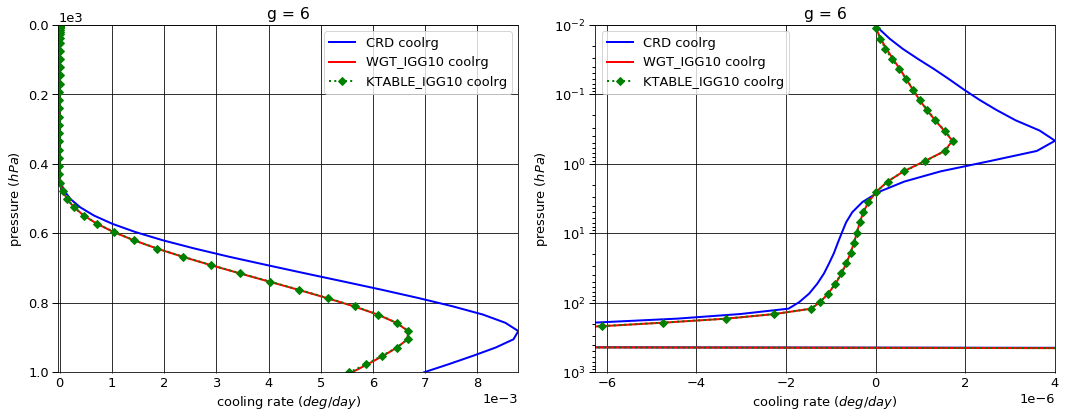

# Figure: cooling rate g-group 7

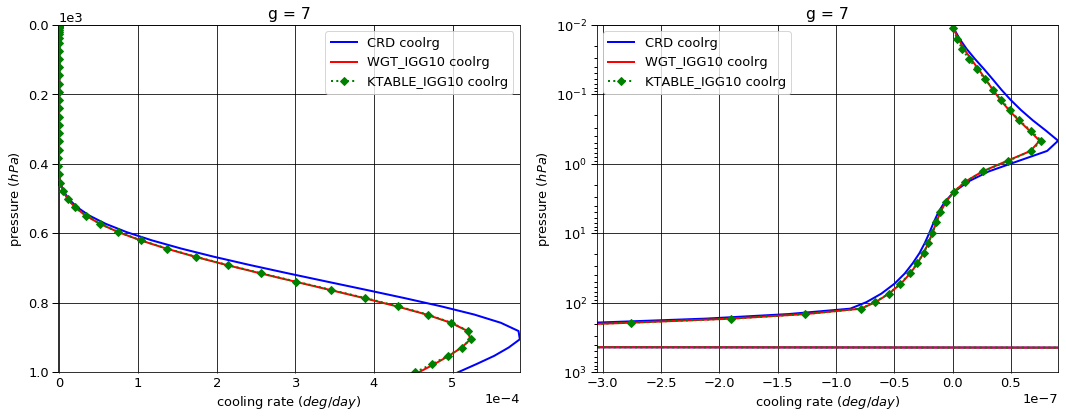

# Figure: cooling rate g-group total

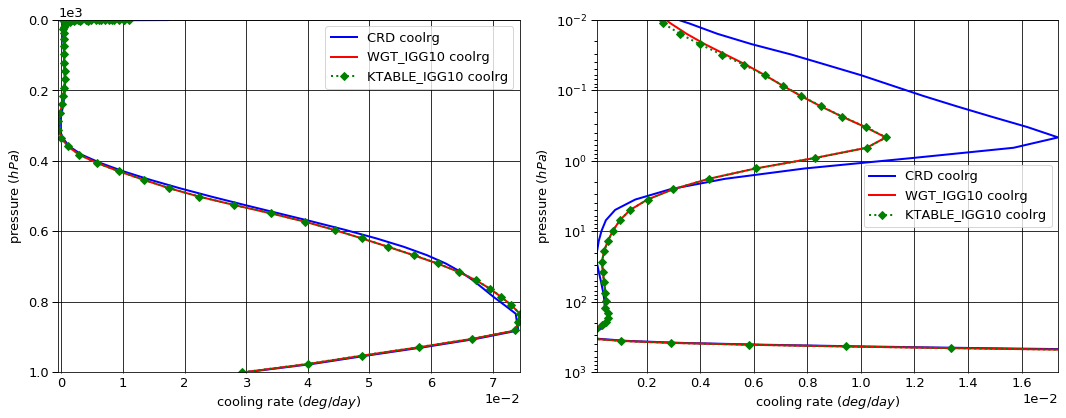

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.017578  0.000000 -0.017578
  1013.0   76    -0.064822  0.064887  0.000065
2 0.0      1     -0.099455  0.000000 -0.099455
  1013.0   76    -0.257841  0.258582  0.000741
3 0.0      1     -0.422179  0.000000 -0.422179
  1013.0   76    -0.712436  0.721979  0.009543
4 0.0      1     -1.550016  0.000000 -1.550016
  1013.0   76    -1.862684  1.752935 -0.109749
5 0.0      1     -2.709781  0.000000 -2.709781
  1013.0   76    -2.819059  1.377619 -1.441439
6 0.0      1     -2.911299  0.000000 -2.911299
  1013.0   76    -2.926526  0.327668 -2.598858
7 0.0      1     -0.913862  0.000000 -0.913862
  1013.0   76    -0.914661  0.021322 -0.893339


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.016212  0.000000 -0.016212
  1013.0   76    -0.064822  0.064887  0.000065
2 0.0      1     -0.095365  0.000000 -0.095365
  1013.0   76    -0.257841  0.258455  0.000613
3 0.0      1     -0.417692  0.000000 -0.417692
  1013.0   76    -0.712436  0.721045  0.008608
4 0.0      1     -1.567961  0.000000 -1.567961
  1013.0   76    -1.862684  1.848136 -0.014548
5 0.0      1     -2.738415  0.000000 -2.738415
  1013.0   76    -2.819059  1.265621 -1.553437
6 0.0      1     -2.915942  0.000000 -2.915942
  1013.0   76    -2.926526  0.246817 -2.679709
7 0.0      1     -0.913968  0.000000 -0.913968
  1013.0   76    -0.914661  0.018918 -0.895743


KTABLE_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.016211  0.000000 -0.016211
  1013.0   76    -0.064822  0.064887  0.000065
2 0.0      1     -0.095313  0.000000 -0.095313
  1013.0   76    -0.257841  0.258457  0.000615
3 0.0      1     -0.417415  0.000000 -0.417415
  1013.0   76    -0.712436  0.721068  0.008631
4 0.0      1     -1.567160  0.000000 -1.567160
  1013.0   76    -1.862684  1.848378 -0.014306
5 0.0      1     -2.738020  0.000000 -2.738020
  1013.0   76    -2.819059  1.266094 -1.552965
6 0.0      1     -2.915863  0.000000 -2.915863
  1013.0   76    -2.926526  0.247061 -2.679465
7 0.0      1     -0.913961  0.000000 -0.913961
  1013.0   76    -0.914661  0.018946 -0.895716


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.365986e-03  0.000000  0.001366
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      4.089920e-03  0.000000  0.004090
  1013.0   76     0.000000e+00 -0.000128 -0.000128
3 0.0      1      4.486850e-03  0.000000  0.004487
  1013.0   76     0.000000e+00 -0.000935 -0.000935
4 0.0      1     -1.794450e-02  0.000000 -0.017945
  1013.0   76     0.000000e+00  0.095200  0.095200
5 0.0      1     -2.863450e-02  0.000000 -0.028635
  1013.0   76     0.000000e+00 -0.111998 -0.111998
6 0.0      1     -4.642700e-03  0.000000 -0.004643
  1013.0   76     0.000000e+00 -0.080851 -0.080851
7 0.0      1     -1.054300e-04  0.000000 -0.000105
  1013.0   76     1.110223e-16 -0.002405 -0.002405


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.366606e-03  0.000000  0.001367
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      4.142178e-03  0.000000  0.004142
  1013.0   76     0.000000e+00 -0.000126 -0.000126
3 0.0      1      4.763970e-03  0.000000  0.004764
  1013.0   76     0.000000e+00 -0.000912 -0.000912
4 0.0      1     -1.714390e-02  0.000000 -0.017144
  1013.0   76     0.000000e+00  0.095443  0.095443
5 0.0      1     -2.823950e-02  0.000000 -0.028240
  1013.0   76     0.000000e+00 -0.111526 -0.111526
6 0.0      1     -4.563900e-03  0.000000 -0.004564
  1013.0   76     0.000000e+00 -0.080606 -0.080606
7 0.0      1     -9.881000e-05  0.000000 -0.000099
  1013.0   76     1.110223e-16 -0.002377 -0.002377

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -9.999580e-04
  1001.112500 75    -1.895231e-05
2 0.000312    1      2.367786e-06
  1001.112500 75    -2.053863e-04
3 0.000312    1     -7.557435e-06
  1001.112500 75    -1.738498e-03
4 0.000312    1     -2.912609e-05
  1001.112500 75     4.712035e-03
5 0.000312    1     -9.575276e-06
  1001.112500 75     1.961010e-02
6 0.000312    1     -7.650333e-07
  1001.112500 75     6.980221e-03
7 0.000312    1     -1.412909e-08
  1001.112500 75     5.068293e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      3.130089e-04
  1001.112500 75    -1.895231e-05
2 0.000312    1      1.070432e-05
  1001.112500 75    -1.742172e-04
3 0.000312    1     -1.957007e-05
  1001.112500 75    -1.888860e-03
4 0.000312    1     -1.734813e-05
  1001.112500 75     3.876075e-03
5 0.000312    1     -4.995727e-06
  1001.112500 75     2.177067e-02
6 0.000312    1     -3.554653e-07
  1001.112500 75     5.597819e-03
7 0.000312    1     -1.185055e-08
  1001.112500 75     4.569783e-04


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1      2.772508e-04
  1001.112500 75    -1.895231e-05
2 0.000312    1      9.252383e-06
  1001.112500 75    -1.748129e-04
3 0.000312    1     -1.642797e-05
  1001.112500 75    -1.890217e-03
4 0.000312    1     -1.630820e-05
  1001.112500 75     3.843702e-03
5 0.000312    1     -4.719678e-06
  1001.112500 75     2.162811e-02
6 0.000312    1     -2.935933e-07
  1001.112500 75     5.551131e-03
7 0.000312    1     -8.764450e-09
  1001.112500 75     4.523826e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.312967e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      8.336534e-06
  1001.112500 75     3.116913e-05
3 0.000312    1     -1.201263e-05
  1001.112500 75    -1.503624e-04
4 0.000312    1      1.177796e-05
  1001.112500 75    -8.359596e-04
5 0.000312    1      4.579549e-06
  1001.112500 75     2.160569e-03
6 0.000312    1      4.095680e-07
  1001.112500 75    -1.382402e-03
7 0.000312    1      2.278546e-09
  1001.112500 75    -4.985098e-05


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.277209e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      6.884597e-06
  1001.112500 75     3.057342e-05
3 0.000312    1     -8.870535e-06
  1001.112500 75    -1.517186e-04
4 0.000312    1      1.281789e-05
  1001.112500 75    -8.683324e-04
5 0.000312    1      4.855598e-06
  1001.112500 75     2.018016e-03
6 0.000312    1      4.714400e-07
  1001.112500 75    -1.429090e-03
7 0.000312    1      5.364641e-09
  1001.112500 75    -5.444667e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.624171,0.000000,-8.624171
1013.0,76,-9.558030,4.524993,-5.033037



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.665555,0.000000,-8.665555
1013.0,76,-9.558030,4.423878,-5.134153



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.663944,0.00000,-8.663944
1013.0,76,-9.558030,4.42489,-5.133140



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.041384,0.000000,-0.041384
1013.0,76,0.000000,-0.101115,-0.101116



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.039773,0.000000,-0.039773
1013.0,76,0.000000,-0.100103,-0.100103


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.001045
1001.112500,75,0.029846



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000281
1001.112500,75,0.029620



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000249
1001.112500,75,0.029391



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001326
1001.112500,75,-0.000227



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001293
1001.112500,75,-0.000455


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008455,0.006707
2,0.031727,0.026763
3,0.084848,0.074071
4,0.218515,0.193788
5,0.300788,0.294611
6,0.276970,0.307518
7,0.078697,0.096542


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.686315e-20
2,2.515606e-21
3,3.752724e-22
4,5.598228e-23
5,8.351308e-24
6,1.245829e-24
7,1.858499e-25


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.686315e-20,NaN,0.008455,0.006707,0.008455,0.006707,600.0
2,2.515606e-21,0.149178,0.031727,0.026763,0.040182,0.033469,600.0
3,3.752724e-22,0.149178,0.084848,0.074071,0.125030,0.107541,600.0
4,5.598228e-23,0.149178,0.218515,0.193788,0.343545,0.301328,600.0
5,8.351308e-24,0.149178,0.300788,0.294611,0.644333,0.595939,600.0
6,1.245829e-24,0.149178,0.276970,0.307518,0.921303,0.903458,600.0
7,1.858499e-25,0.149178,0.078697,0.096542,1.000000,1.000000,600.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     2.984217e-20  1.495940e-21  19.948771  1.334395e-06
      2 0.000312     1.868453e-21  9.712868e-23  19.236879  8.369558e-08
      3 0.000312     1.477717e-22  1.090052e-23  13.556392  6.756354e-09
      4 0.000312     2.126540e-23  1.651491e-24  12.876487  9.758146e-10
      5 0.000312     3.243569e-24  2.107278e-25  15.392219  1.470859e-10
      6 0.000312     2.112610e-25  2.257174e-26   9.359533  9.956731e-12
      7 0.000312     1.231905e-26  2.427557e-27   5.074669  9.648673e-13
2     1 0.000750     3.056489e-20  1.506005e-21  20.295340  5.500442e-07
      2 0.000750     1.915591e-21  9.830678e-23  19.485843  3.454013e-08
      3 0.000750     1.515548e-22  1.100233e-23  13.774802  2.788000e-09
      4 0.000750     2.149164e-23  1.669163e-24  12.875703  3.972284e-10
      5 0.000750     3.294269e-24  2.136876e-25  15.416285  6.016457e-11
      6 0.000750     2.171302e-25  2.297140e-26   9.452195  4.117955e-12
      7 0.000750     1.270081e-26  2.468535e-27   5.145080  4.005618e-13
3     1 0.001052     3.206629e-20  1.525915e-21  21.014464  8.079649e-07
      2 0.001052     2.014314e-21  1.006331e-22  20.016409  5.086903e-08
      3 0.001052     1.595352e-22  1.120621e-23  14.236322  4.106699e-09
      4 0.001052     2.197209e-23  1.705039e-24  12.886559  5.694860e-10
      5 0.001052     3.399899e-24  2.197175e-25  15.473952  8.705958e-11
      6 0.001052     2.294983e-25  2.379739e-26   9.643841  6.092307e-12
      7 0.001052     1.351913e-26  2.554827e-27   5.291604  5.975855e-13
4     1 0.001476     3.364467e-20  1.545862e-21  21.764343  1.187419e-06
      2 0.001476     2.119259e-21  1.029392e-22  20.587487  7.498270e-08
      3 0.001476     1.681029e-22  1.141305e-23  14.729017  6.057333e-09
      4 0.001476     2.249350e-23  1.742104e-24  12.911685  8.177718e-10
      5 0.001476     3.511622e-24  2.259721e-25  15.540066  1.261161e-10
      6 0.001476     2.427652e-25  2.466540e-26   9.842341  9.023799e-12
      7 0.001476     1.441818e-26  2.648109e-27   5.444707  8.935825e-13
5     1 0.002070     3.528242e-20  1.565619e-21  22.535770  1.743904e-06
      2 0.002070     2.229424e-21  1.051891e-22  21.194438  1.104900e-07
      3 0.002070     1.771904e-22  1.162016e-23  15.248545  8.935821e-09
      4 0.002070     2.305372e-23  1.779964e-24  12.951790  1.175301e-09
      5 0.002070     3.628600e-24  2.323905e-25  15.614237  1.827287e-10
      6 0.002070     2.568331e-25  2.556514e-26  10.046223  1.336503e-11
      7 0.002070     1.539495e-26  2.747579e-27   5.603097  1.337478e-12
6     1 0.002904     3.698042e-20  1.585231e-21  23.328097  2.560267e-06
      2 0.002904     2.345025e-21  1.073809e-22  21.838386  1.628084e-07
      3 0.002904     1.868293e-22  1.182757e-23  15.796076  1.318828e-08
      4 0.002904     2.365677e-23  1.818664e-24  13.007778  1.691244e-09
      5 0.002904     3.751359e-24  2.389895e-25  15.696749  2.649082e-10
      6 0.002904     2.717612e-25  2.649683e-26  10.256367  1.980052e-11
      7 0.002904     1.645713e-26  2.853286e-27   5.767782  2.004462e-12
7     1 0.004074     3.873955e-20  1.604773e-21  24.140208  3.757115e-06
      2 0.004074     2.466286e-21  1.095169e-22  22.519682  2.398749e-07
      3 0.004074     1.970530e-22  1.203567e-23  16.372418  1.947164e-08
      4 0.004074     2.430710e-23  1.858251e-24  13.080630  2.436681e-09
      5 0.004074     3.880499e-24  2.457894e-25  15.787903  3.842657e-10
      6 0.004074     2.876164e-25  2.746126e-26  10.473532  2.934200e-11
      7 0.004074     1.761335e-26  2.965140e-27   5.940140  3.007704e-12
8     1 0.005714     4.056099e-20  1.624363e-21  24.970405  5.510519e-06
      2 0.005714     2.593461e-21  1.116048e-22  23.237897  3.533529e-07
      3 0.005714     2.078990e-22  1.224523e-23  16.977952  2.875663e-08
      4 0.005714     2.500965e-23  1.898789e-24  13.171367  3.514951e-09
      5 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
